# Image Processing Project

## UTILITIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
#           LOADING AND SAVING
# ==========================================

def load_txt_image(path):
    img = np.loadtxt(path, dtype=float)
    if img.max() > 1.0:
        img = img / 255.0
    return img

def save_txt_image(path, img):
    fmt = "%d" if img.dtype in [np.int32, np.int64, np.uint8] else "%.6f"
    np.savetxt(path, img, fmt=fmt)

# ==========================================
#        INTEGRAL IMAGE + WINDOW SUM
# ==========================================

def compute_integral_image(I):
    return np.cumsum(np.cumsum(I, axis=0), axis=1)

def local_sum_integral(g, x, y, w):
    d = w // 2

    x1 = max(x - d, 0)
    y1 = max(y - d, 0)
    x2 = min(x + d, g.shape[0] - 1)
    y2 = min(y + d, g.shape[1] - 1)

    A = g[x2, y2]
    B = g[x1 - 1, y2] if x1 > 0 else 0
    C = g[x2, y1 - 1] if y1 > 0 else 0
    D = g[x1 - 1, y1 - 1] if (x1 > 0 and y1 > 0) else 0

    return A - B - C + D

def quick_plot(x, y, xlabel='', ylabel='', title='', show=True):
    """Crea plot base di x-y."""
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show:
        plt.show()

def scatter_plot(x, y, xlabel='', ylabel='', title='', show=True):
    """Scatter plot semplice."""
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show:
        plt.show()

## METHOD 1: PROPOSED (Singh & al.)

In [3]:
def binarize_proposed(I, w=15, k=0.06):
    g = compute_integral_image(I)
    n, m = I.shape
    B = np.zeros_like(I)

    for x in range(n):
        for y in range(m):
            s = local_sum_integral(g, x, y, w)
            mxy = s / (w * w)

            dxy = I[x, y] - mxy

            if abs(1 - dxy) < 1e-9:
                T = mxy
            else:
                T = mxy * (1 + k * (dxy / (1 - dxy)))

            B[x, y] = 0 if I[x, y] <= T else 1

    return B.astype(int)

## METHOD 2: SAUVOLA

In [4]:
def binarize_sauvola(I, w=15, k=0.06, R=0.5):
    g = compute_integral_image(I)
    n, m = I.shape
    B = np.zeros_like(I)

    g2 = compute_integral_image(I**2)

    for x in range(n):
        for y in range(m):

            s = local_sum_integral(g, x, y, w)
            s2 = local_sum_integral(g2, x, y, w)

            area = w * w
            mxy = s / area
            var = (s2 / area) - mxy**2
            std = np.sqrt(max(var, 0.0))

            T = mxy * (1 + k * (std / R - 1))

            B[x, y] = 0 if I[x, y] <= T else 1

    return B.astype(int)

## METHOD 3: NIBLACK

In [5]:
def binarize_niblack(I, w=15, k=-0.2):
    g = compute_integral_image(I)
    g2 = compute_integral_image(I**2)
    n, m = I.shape
    B = np.zeros_like(I)

    for x in range(n):
        for y in range(m):

            s = local_sum_integral(g, x, y, w)
            s2 = local_sum_integral(g2, x, y, w)

            area = w * w
            mxy = s / area
            var = (s2 / area) - mxy**2
            std = np.sqrt(max(var, 0.0))

            T = mxy + k * std

            B[x, y] = 0 if I[x, y] <= T else 1

    return B.astype(int)

## METHOD 4: BERNSEN

In [ ]:
def binarize_bernsen(I, w=31, contrast_threshold=15/255.0):
    n, m = I.shape
    B = np.zeros_like(I)

    # COPIA DI LETTURA: non la modifichi mai
    I_orig = I.copy()

    if I_orig.max() <= 1.0:
        img = (I_orig * 255).astype(np.uint8)
    else:
        img = I_orig.astype(np.uint8)

    # Istogramma per Otsu
    hist, _ = np.histogram(img, bins=256, range=(0,256))
    total = img.size

    prob = hist / total
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]
    sigma_b = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-12)
    T_otsu = np.argmax(sigma_b)

    d = w // 2

    for x in range(n):
        for y in range(m):

            x1 = max(x - d, 0)
            x2 = min(x + d, n - 1)
            y1 = max(y - d, 0)
            y2 = min(y + d, m - 1)

            region = I_orig[x1:x2+1, y1:y2+1]

            Imax = region.max()
            Imin = region.min()
            C = Imax - Imin

            T = 0.5 * (Imax + Imin)

            if C < contrast_threshold:
                # NON modificare I_original!
                if np.mean(region) < T_otsu:
                    B[x1:x2+1, y1:y2+1] = 0
                else:
                    B[x1:x2+1, y1:y2+1] = 1
            else:
                B[x, y] = 0 if I_orig[x, y] <= T else 1

    return B.astype(int)

## METHOD 6: OTSU (Global)

In [7]:
def binarize_otsu(I):
    if I.max() <= 1.0:
        img = (I * 255).astype(np.uint8)
    else:
        img = I.astype(np.uint8)

    # Istogramma
    hist, _ = np.histogram(img, bins=256, range=(0,256))
    total = img.size

    # Probabilità per livello
    prob = hist / total

    # Calcoli cumulativi
    omega = np.cumsum(prob)                 # peso delle classi
    mu = np.cumsum(prob * np.arange(256))   # media cumulata

    # media globale
    mu_t = mu[-1]

    # Varianza interclasse
    sigma_b = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-12)

    # Soglia ottima
    T = np.argmax(sigma_b)

    # Binarizzazione
    B = (img > T).astype(int)
    return B

## METHOD 7: GENERALIZATIONS

In [8]:
def binarize_sigmoid(I, w, k, a, b):
    g = compute_integral_image(I)
    n, m = I.shape
    B = np.zeros_like(I)

    for x in range(n):
        for y in range(m):
            s = local_sum_integral(g, x, y, w)
            mxy = s / (w * w)

            dxy = I[x, y] - mxy

            if abs(1 - dxy) < 1e-9:
                T = mxy
            else:
                T = mxy * (1 + k * 1 / (np.exp(-a * (dxy - b))))

            B[x, y] = 0 if I[x, y] <= T else 1

    return B.astype(int)

def binarize_tanh(I, w, k):
    g = compute_integral_image(I)
    n, m = I.shape
    B = np.zeros_like(I)

    for x in range(n):
        for y in range(m):
            s = local_sum_integral(g, x, y, w)
            mxy = s / (w * w)

            dxy = I[x, y] - mxy

            if abs(1 - dxy) < 1e-9:
                T = mxy
            else:
                T = mxy * (1 + k * np.tanh(dxy))

            B[x, y] = 0 if I[x, y] <= T else 1

    return B.astype(int)


## USER INTERFACE

In [9]:
if __name__ == "__main__":

    # BOH PARAMETER
    k = 0.3
    # WINDOW SIZE: MUST BE AN ODD NUMBER
    w = 5
    # SIGMOID PARAMETERS (TBD)
    a = 0.01
    b = 0.
    method = "bernsen"
    input = "input/blobs.txt"
    output = "output/blobs_bin.txt"
    I = load_txt_image(input)

    match method:
        case "proposed":
            B = binarize_proposed(I, w, k)
        case "sauvola":
            B = binarize_sauvola(I, w, k)
        case "niblack":
            B = binarize_niblack(I, w, k)
        case "bernsen":
            B = binarize_bernsen(I)
        case "otsu":
            B = binarize_otsu(I)
        case "sigmoid":
            B = binarize_sigmoid(I, w, k, a, b)
        case "tanh":
            B = binarize_tanh(I, w, k)
        case None:
            B = I

    save_txt_image(output, B)

    print(f"Metodo '{method}' completato. Output salvato come {output}")

Metodo 'bernsen' completato. Output salvato come output/blobs_bin.txt


## TESTING (RunTime)

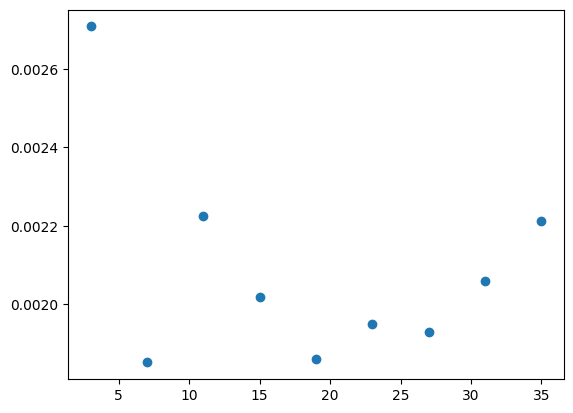

In [ ]:
import time

N = 10 # int(1e3)

# Testing on the same image N times, recording RunTimes for different methods

input = "input/blobs.txt"
output = "output/blobs_bin.txt"
I = load_txt_image(input)
k = 0.06
w_list = [3, 7, 11, 15, 19, 23, 27, 31, 35]
t_list = []
avg_t = []
# print(w_list)

# Testing Otsu method
for w in w_list:
    for i in range(N):
        start = time.time()
        _ = binarize_otsu(I)
        dt = time.time() - start
        t_list.append(dt)
    
    avg_t.append(np.mean(t_list))
    t_list.clear()

scatter_plot(w_list, avg_t)

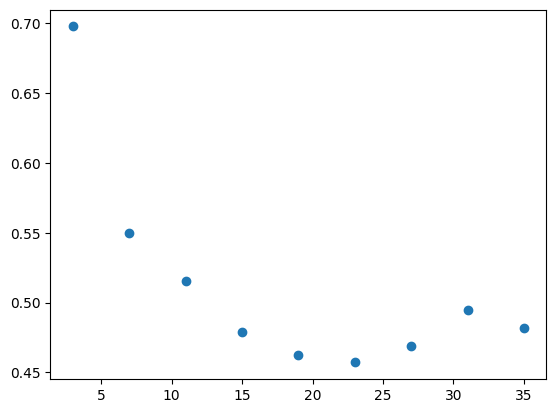

In [11]:
avg_t = []

# Testing Sauvola method
for w in w_list:
    for i in range(N):
        start = time.time()
        _ = binarize_sauvola(I, w)
        dt = time.time() - start
        t_list.append(dt)
    
    avg_t.append(np.mean(t_list))

scatter_plot(w_list, avg_t)

## TESTING (Accuracy)